In [53]:
import numpy as np
from keras import applications, callbacks
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers

import keras.backend as K

In [54]:
x_train=np.load('dataset/x_train_np.npy')
x_cv=np.load('dataset/x_cv_np.npy')
y_train=np.load('dataset/y_train_np.npy')
y_cv=np.load('dataset/y_cv_np.npy')

In [55]:
x_test=np.load('dataset/x_test_np.npy', allow_pickle=True)
y_test=np.load('dataset/y_test_np.npy')

ResNet50 Bottleneck

In [56]:
model = applications.resnet50.ResNet50(weights='imagenet', include_top=False)

x_train_bottleneck = model.predict(x_train)
x_cv_bottleneck = model.predict(x_cv)

np.save('dataset/x_train_bottleneck_resnet.npy', x_train_bottleneck)
np.save('dataset/x_cv_bottleneck_resnet.npy', x_cv_bottleneck)

print(x_train_bottleneck[0].shape)

(2, 2, 2048)


In [57]:
x_train_bottleneck[0]

array([[[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 1.3101416, 0.9303782,
         1.0126715]],

       [[0.       , 0.       , 0.       , ..., 6.6205463, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 1.1534111, 0.       ,
         0.       ]]], dtype=float32)

In [58]:
x_train_bottleneck = np.load('dataset/x_train_bottleneck_resnet.npy')
x_cv_bottleneck = np.load('dataset/x_cv_bottleneck_resnet.npy')

In [59]:
x_train_bottleneck.shape[1:]

(2, 2, 2048)

Top Model

In [60]:
x_train_bottleneck.shape

(6800, 2, 2, 2048)

In [61]:
top_model=Sequential()
top_model.add(Flatten(input_shape=x_train_bottleneck.shape[1:]))
top_model.add(Dense(64, activation='relu'))
# top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [62]:
top_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 524,417
Trainable params: 524,417
Non-trainable params: 0
_________________________________________________________________


In [63]:
class Custom_lr(callbacks.Callback):

    def on_train_begin(self, logs={}):
	    K.set_value(self.model.optimizer.lr, 0.001)
 
    def on_epoch_begin(self, epoch, logs={}):
        lr_present=K.get_value(self.model.optimizer.lr)
        #print(epoch)
        if (epoch%10==0) and epoch:
        	
            K.set_value(self.model.optimizer.lr, lr_present/((epoch)**0.5))
            print(K.get_value(self.model.optimizer.lr))
            print(lr_present/((epoch)**0.5))

callbacks = [
    Custom_lr()
    ]

In [64]:
top_model.fit(x_train_bottleneck, y_train,
          epochs=35,
          batch_size=32,
          validation_data=(x_cv_bottleneck, y_cv), callbacks=callbacks,)

Epoch 1/35
213/213 [==============================] - 1s 6ms/step - loss: 0.6483 - accuracy: 0.6599 - val_loss: 0.5744 - val_accuracy: 0.7074
Epoch 2/35
213/213 [==============================] - 1s 6ms/step - loss: 0.4712 - accuracy: 0.7712 - val_loss: 0.5471 - val_accuracy: 0.7293
Epoch 3/35
213/213 [==============================] - 1s 6ms/step - loss: 0.3450 - accuracy: 0.8401 - val_loss: 0.5617 - val_accuracy: 0.7266
Epoch 4/35
213/213 [==============================] - 1s 6ms/step - loss: 0.2257 - accuracy: 0.9057 - val_loss: 0.5883 - val_accuracy: 0.7523
Epoch 5/35
213/213 [==============================] - 1s 6ms/step - loss: 0.1499 - accuracy: 0.9437 - val_loss: 0.6585 - val_accuracy: 0.7516
Epoch 6/35
213/213 [==============================] - 1s 6ms/step - loss: 0.1034 - accuracy: 0.9650 - val_loss: 0.7732 - val_accuracy: 0.7630
Epoch 7/35
213/213 [==============================] - 1s 5ms/step - loss: 0.0665 - accuracy: 0.9782 - val_loss: 0.7542 - val_accuracy: 0.7667
Epoch 

In [65]:
top_model.save('top_model_resnet_full_data_custom_lr_weights.h5') # best

Fine Tune Model

In [66]:
x_train = np.load('dataset/x_train_np.npy')
x_cv = np.load('dataset/x_cv_np.npy')

y_train=np.load('dataset/y_train_np.npy')
y_cv=np.load('dataset/y_cv_np.npy')

In [67]:
resnet_model=applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [68]:
model_aug=Sequential()
model_aug.add(resnet_model)

In [69]:
top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights('top_model_resnet_full_data_custom_lr_weights.h5')

model_aug.add(top_model)

In [70]:
for layer in model_aug.layers[0].layers[:171]:
    layer.trainable=False

In [71]:
model_aug.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3), metrics=['accuracy'])

In [72]:
model_aug.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 524417    
Total params: 24,112,129
Trainable params: 1,579,137
Non-trainable params: 22,532,992
_________________________________________________________________


In [73]:
model_aug.fit(x_train, y_train, epochs=35, batch_size=32, validation_data=(x_cv, y_cv), verbose=1)

Epoch 1/35
213/213 [==============================] - 83s 391ms/step - loss: 0.2610 - accuracy: 0.9168 - val_loss: 0.9323 - val_accuracy: 0.7283
Epoch 2/35
213/213 [==============================] - 82s 384ms/step - loss: 0.1255 - accuracy: 0.9540 - val_loss: 0.9370 - val_accuracy: 0.7530
Epoch 3/35
213/213 [==============================] - 83s 390ms/step - loss: 0.1034 - accuracy: 0.9654 - val_loss: 1.0176 - val_accuracy: 0.7571
Epoch 4/35
213/213 [==============================] - 95s 448ms/step - loss: 0.0664 - accuracy: 0.9762 - val_loss: 1.2324 - val_accuracy: 0.7431
Epoch 5/35
213/213 [==============================] - 89s 418ms/step - loss: 0.0584 - accuracy: 0.9796 - val_loss: 1.0217 - val_accuracy: 0.7633
Epoch 6/35
213/213 [==============================] - 82s 386ms/step - loss: 0.0461 - accuracy: 0.9834 - val_loss: 0.9541 - val_accuracy: 0.7695
Epoch 7/35
213/213 [==============================] - 83s 388ms/step - loss: 0.0303 - accuracy: 0.9888 - val_loss: 1.0497 - val_ac

In [76]:
model_aug.save('fine_tuned_model_resnet_adam_weights_new_35epoch.h5')

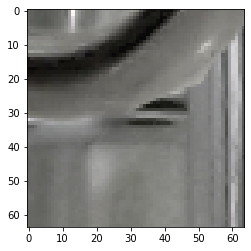

In [75]:
import matplotlib.pyplot as plt

plt.imshow(x_train[1])

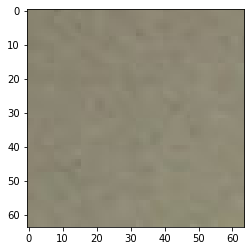

In [42]:
plt.imshow(x_test[1][0])

In [149]:
i = 0
for data in x_test[3:10]:
    result = model_aug.predict(data)
    print(f'[{i}] Fake {(result > 0.75).sum()/len(result) <= 0.25}')
    i+=1

[0] Fake False
[1] Fake False
[2] Fake False
[3] Fake True
[4] Fake False
[5] Fake True
[6] Fake False


In [102]:
result = model_aug.predict(x_test[10])
print(f'Max: {max(result)}, Min: {min(result)}')

Max: [1.], Min: [2.295853e-11]


In [100]:
y_test[220]

1

In [101]:
result.reshape(12, 16)

array([[9.1445446e-04, 2.2598803e-03, 7.9812050e-02, 9.9640334e-01,
        1.3844490e-02, 1.3983201e-06, 3.0139506e-02, 9.9808096e-07,
        5.8822036e-03, 1.2648800e-01, 7.4787766e-01, 6.0313940e-04,
        1.8473077e-06, 1.0452455e-05, 4.3603677e-07, 6.9673558e-07],
       [5.7512301e-07, 1.4875323e-02, 1.2804747e-02, 4.1979551e-04,
        8.1878400e-01, 1.0000000e+00, 9.9796498e-01, 2.5364757e-04,
        9.9601716e-01, 3.0555409e-01, 4.2076111e-03, 9.9926955e-01,
        9.9881554e-01, 6.4523047e-05, 3.8576229e-07, 1.3376660e-05],
       [5.1900744e-03, 1.4890134e-03, 6.2037066e-07, 1.3156068e-05,
        7.5560808e-03, 5.1801676e-01, 9.5696080e-01, 9.9986696e-01,
        4.5154837e-07, 7.9190451e-01, 2.3629063e-01, 8.2844496e-04,
        2.6588752e-06, 9.9596453e-01, 6.3081330e-01, 9.9890882e-01],
       [5.1956242e-01, 5.3042769e-03, 1.5091747e-02, 9.9998540e-01,
        9.9828804e-01, 2.2721291e-04, 2.9186338e-02, 1.0000000e+00,
        2.1402538e-02, 6.7108589e-01, 1.56903

In [106]:
np.count_nonzero(result > 0.5)/len(result) > 0.5

False

In [82]:
len(result)

192

In [102]:
x_train[1].shape

(64, 64, 3)

In [ ]:
x_test[1]

In [113]:
result = model_aug.predict_classes(x_test[2])

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])